# Dynamic recalibration of DTS observations using "raw" observations

Part of the "VertHarpExp2017Kloendeel" (Vertical Harp Spectral Response Kloendeel Experiment), testing the spectral response of the two DTS instruments (Ultima and XT) against the eddy covariance observations made as part of the Micrometeorology Summer School, Kloendeel 2017

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys
import pickle
import os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Offline Turbulence Package
import turbpy

# Customize
sns.set_style("whitegrid")
sns.set_context('talk')
%matplotlib inline

# XML
import xmltodict

In [2]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists
# Unix
if 'linux' in sys.platform:
    dirPre = '/home/lapok/gdrive/DarkMix/'
# Mac
elif 'darwin' in sys.platform:
    dirPre = '/Users/karllapo/gdrive/DarkMix/'

dirData = dirPre + 'proj/exampleDTS/data/VertHarpExp2017Kloendeel/UltimaVHSRE'
dirPrint = dirPre + 'graphics'
dirProcessed = dirPre + 'proj/exampleDTS/data/VertHarpExp2017Kloendeel/DTS_processed'

## Location library for labeling

In [3]:
def labelLocation(ds):

    location = {
        ########################
        ## Near vertical harp ##
        ########################
        # Segment 1, up and over ~ 47.3 to 50.8. 2m vertical separation,
        # tentatively assign 47.3 to 48.5 as the upward limb.
        'vertHarpNear_1': [47.3, 48.5],
        # Segment 2, up and over ~ 47.3 to 50.8. 2m vertical separation,
        # tentatively assign 50.8 to 49.3 as the downward limb.
        'vertHarpNear_2': [49.3, 50.8],
        # Segment 3, up and over ~ 51.5 to 54.9. 2m vertical separation,
        # tentatively assign 51.5 to 53.0 as the upward limb.
        'vertHarpNear_3': [51.5, 53.0],
        # Segment 4, up and over ~ 51.5 to 54.9. 2m vertical separation,
        # tentatively assign 53.4 to 54.9 as the downward limb.
        'vertHarpNear_4': [53.4, 54.9],

        #######################
        ## Far vertical harp ##
        #######################
        # Segment 1, up and over ~ 326.2 to 329.75. 2m vertical separation,
        # tentatively assign 326.2 to 327.7 as the upward limb.
        'vertHarpFar_1': [326.2, 327.7],
        # Segment 2, up and over ~ 326.2 to 329.75. 2m vertical separation,
        # tentatively assign 329.75 to 328.25 as the downward limb.
        'vertHarpFar_2': [328.25, 329.75],
        # Segment 3, up and over ~ 330.4 to 333.75. 2m vertical separation,
        # tentatively assign 330.4 to 331.9 as the upward limb.
        'vertHarpFar_3': [330.4, 331.9],
        # Segment 4, up and over ~ 330.4 to 333.75. 2m vertical separation,
        # tentatively assign 332.25 to 333.75 as the downward limb.
        'vertHarpFar_4': [332.25, 333.75],


        ######################
        ## Horizontal Array ##
        ######################
        'Horizontal - 86cm': [245, 294.5],
        'Horizontal - 84cm': [192.25, 242],
        'Horizontal - 60.5cm': [136, 185.5],
        'Horizontal - 56cm': [82.5, 132],

        #######################
        ## Temperature Baths ##
        #######################
        'warmBathNear': [29, 34],
        'coldBathNear': [17, 22],
        'warmBathFar': [346, 351],
        'coldBathFar': [357, 362],
    }

    # Assign location tags
    ds.coords['location'] = (('LAF'), [None] * ds.LAF.size)
    ds.attrs['locations'] = ';'.join(list(location.keys()))
    for l in location:
        ds.coords['location'].loc[(ds.LAF > location[l][0]) & (ds.LAF < location[l][-1])] = l

    # Assign height values
    locationHeights = {
        'Horizontal - 86cm': 0.86,
        'Horizontal - 84cm': 0.84,
        'Horizontal - 60.5cm': 0.605,
        'Horizontal - 56cm': 0.56,
    }

    return(ds)

In [4]:
def readDumbXMLFiles(dumbXMLFile):
    with open(dumbXMLFile) as dumb:
        doc = xmltodict.parse(dumb.read())
    
    # Remove all of the bullshit
    doc = doc['logs']['log']
    
    # Extract units/metadata info out of xml dictionary
    metaData = {'LAF_beg': float(doc['startIndex']['#text']),
                'LAF_end': float(doc['endIndex']['#text']),
                'dLAF': float(doc['stepIncrement']['#text']),
                'dt_start': pd.to_datetime(doc['startDateTimeIndex'], infer_datetime_format=True),
                'dt_end': pd.to_datetime(doc['endDateTimeIndex'], infer_datetime_format=True),
                'probe1Temperature': float(doc['customData']['probe1Temperature']['#text']),
                'probe2Temperature': float(doc['customData']['probe2Temperature']['#text']),
                'fiberOK': int(doc['customData']['fibreStatusOk']),
               }

    # Extract data
    data = doc['logData']['data']

    numEntries = np.size(data)
    LAF = np.empty(numEntries)
    Ps = np.empty_like(LAF)
    Pas = np.empty_like(LAF)
    temp = np.empty_like(LAF)

    for dnum, dlist in enumerate(data):
        LAF[dnum], Ps[dnum], Pas[dnum], temp[dnum] = list(map(float, dlist.split(',')))

    actualData = pd.DataFrame.from_dict({'LAF': LAF, 'Ps': Ps, 'Pas': Pas, 'temp': temp}).set_index('LAF')
    
    
    return(actualData, metaData)

procFlag = False
if procFlag:
    # List of files to iterate over
    os.chdir(dirData)
    dirCon = [dC for dC in os.listdir() if 'channel 1' in dC]
    nTotal = np.size(dirCon)
    ds = None

    for nDumb, someDumbFiles in enumerate(dirCon):
        if '.xml' in someDumbFiles:
            print("\r", someDumbFiles + 'File ' + str(nDumb) + ' of ' + str(nTotal), end="")
        else:
            continue

        # Read the file
        df, meta = readDumbXMLFiles(someDumbFiles)

        # Create a temporary xarray Dataset
        temp_Dataset = xr.Dataset.from_dataframe(df)
        temp_Dataset.coords['time'] = meta['dt_start']
        temp_Dataset['probe1Temperature'] = meta['probe1Temperature']
        temp_Dataset['probe2Temperature'] = meta['probe2Temperature']
        temp_Dataset['fiberStatus'] = meta['fiberOK']

        if ds:
            ds = xr.concat([ds, temp_Dataset], dim='time')
        else:
            ds = temp_Dataset

        # Chunking/saving to avoid lock-up
        if np.mod(nDumb + 1, 1000) == 0:
            os.chdir(dirProcessed)
            numChunk = np.floor_divide(nDumb, 1000)
            ds.attrs = {'LAF_beg': meta['LAF_beg'],
                        'LAF_end': meta['LAF_end'],
                        'dLAF': meta['dLAF']}
            ds = labelLocation(ds)
            ds.to_netcdf('VHRSE_chunk' + str(numChunk) + '.nc', 'w')
            ds.close()
            ds = None
            os.chdir(dirData)


In [5]:
#########################
## Load processed data ##
#########################
os.chdir(dirProcessed)
ds = xr.open_mfdataset('VHRSE_chunk0.nc')
ds.attrs['locations'] = ds.attrs['locations'].split(';')
print(ds)
print(np.unique(ds.attrs['locations']))

<xarray.Dataset>
Dimensions:            (LAF: 4193, time: 1000)
Coordinates:
  * LAF                (LAF) float64 -83.06 -82.93 -82.8 -82.67 -82.55 ...
  * time               (time) datetime64[ns] 2017-09-04T17:29:38 ...
    location           (LAF) object '' '' '' '' '' '' '' '' '' '' '' '' '' ...
Data variables:
    Pas                (time, LAF) float64 0.1196 -0.9827 13.01 -1.58 -9.542 ...
    Ps                 (time, LAF) float64 -0.7304 1.216 -0.9891 2.12 -11.28 ...
    temp               (time, LAF) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    probe1Temperature  (time) float64 44.38 44.37 44.37 44.37 44.37 44.37 ...
    probe2Temperature  (time) float64 10.88 10.88 10.89 10.88 10.89 10.88 ...
    fiberStatus        (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
Attributes:
    LAF_beg:    -83.055
    dLAF:       0.127
    LAF_end:    449.746
    locations:  ['vertHarpNear_1', 'Horizontal - 84cm', 'Horizontal - 86cm', ...
['Horizontal - 56cm' 'Horizontal - 60.5cm' '

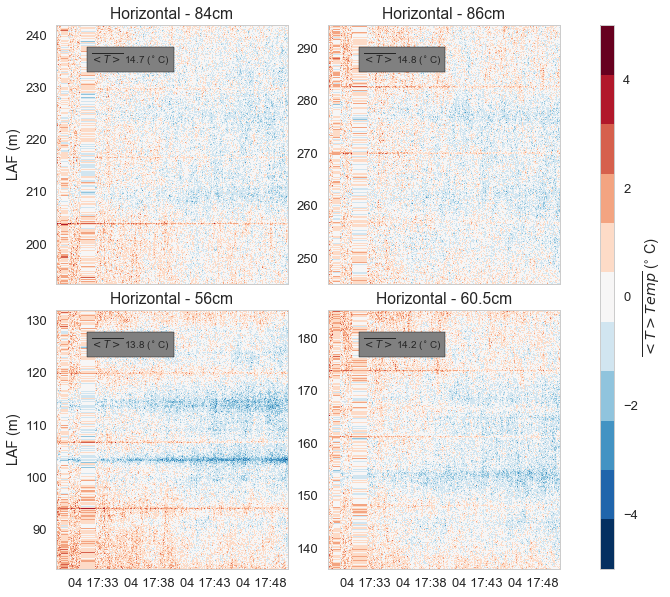

In [6]:
#########################
## Horizontal Segments ##
#########################
fig = plt.figure(figsize=(10, 10))
gs = matplotlib.gridspec.GridSpec(2, 3, width_ratios=np.append(np.ones(2) * 16, np.array(1)))
gs.update(wspace=0.25, hspace=0.1)
axNum = 0
cmap_delta = kgraph.cmap_discretize(cm.RdBu_r, 11)

for loc in ds.attrs['locations']:
    if 'Horizontal' in loc:
        if axNum == 2:
            axNum = axNum + 1
        ax = plt.subplot(gs[axNum])
        axNum = axNum + 1
        
        # Image of data for each section
        temp_ds = ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc)
        meanSectionTemp = temp_ds.mean(dim='time').mean(dim='location')
        temp_ds = temp_ds - meanSectionTemp
        H = np.ma.masked_array(temp_ds.values, np.isnan(temp_ds))
        t = temp_ds.time.values
        length = temp_ds.LAF.values
        X, Y = np.meshgrid(t, length)

        im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap_delta, vmin=-5, vmax=5)

        if not ax.is_last_row():
            ax.set_xticks([])
        if ax.is_first_col():
            ax.set_ylabel('LAF (m)')
        ax.set_title(loc)
        ax.text(0.15, 0.85, '$\overline{<T>}$ '
                + '{:.1f}'.format(np.asscalar(meanSectionTemp.values)) + ' ($^{\circ}$ C)',
                transform=ax.transAxes,
                bbox=dict(facecolor='grey'))
caxi = plt.subplot(gs[:, -1])
cbar = plt.colorbar(im, cax=caxi, orientation='vertical', spacing='prop')
cbar.ax.set_ylabel('$\overline{<T> Temp}$ ($^{\circ}$ C)')

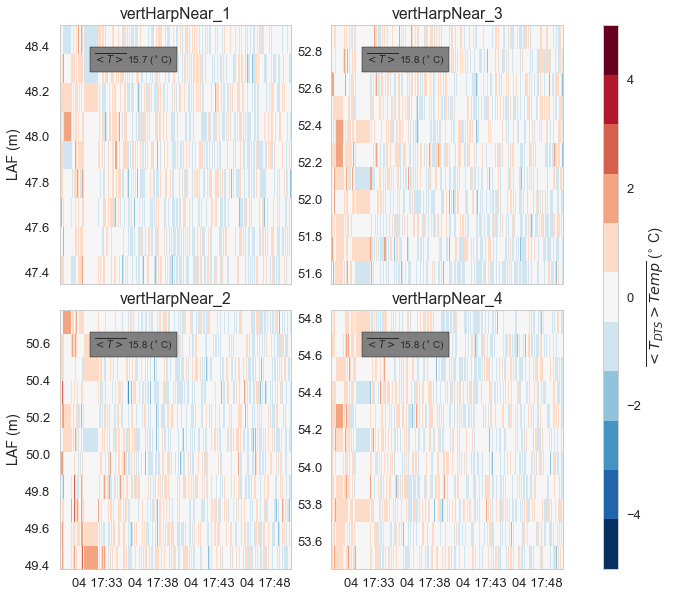

In [7]:
##############################
## Vertical (near) Segments ##
##############################
fig = plt.figure(figsize=(10, 10))
gs = matplotlib.gridspec.GridSpec(2, 3, width_ratios=np.append(np.ones(2) * 16, np.array(1)))
gs.update(wspace=0.25, hspace=0.1)
axNum = 0
cmap_delta = kgraph.cmap_discretize(cm.RdBu_r, 11)

for loc in ds.attrs['locations']:
    if 'vertHarpNear' in loc:
        if axNum == 2:
            axNum = axNum + 1
        ax = plt.subplot(gs[axNum])
        axNum = axNum + 1
        
        # Image of data for each section
        temp_ds = ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc)
        meanSectionTemp = temp_ds.mean(dim='time').mean(dim='location')
        temp_ds = temp_ds - meanSectionTemp
        H = np.ma.masked_array(temp_ds.values, np.isnan(temp_ds))
        t = temp_ds.time.values
        length = temp_ds.LAF.values
        X, Y = np.meshgrid(t, length)

        im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap_delta, vmin=-5, vmax=5)

        if not ax.is_last_row():
            ax.set_xticks([])
        if ax.is_first_col():
            ax.set_ylabel('LAF (m)')
        ax.set_title(loc)
        ax.text(0.15, 0.85, '$\overline{<T>}$ '
                + '{:.1f}'.format(np.asscalar(meanSectionTemp.values)) + ' ($^{\circ}$ C)',
                transform=ax.transAxes,
                bbox=dict(facecolor='grey'))

caxi = plt.subplot(gs[:, -1])
cbar = plt.colorbar(im, cax=caxi, orientation='vertical', spacing='prop')
cbar.ax.set_ylabel('$\overline{<T_{DTS}> Temp}$ ($^{\circ}$ C)')

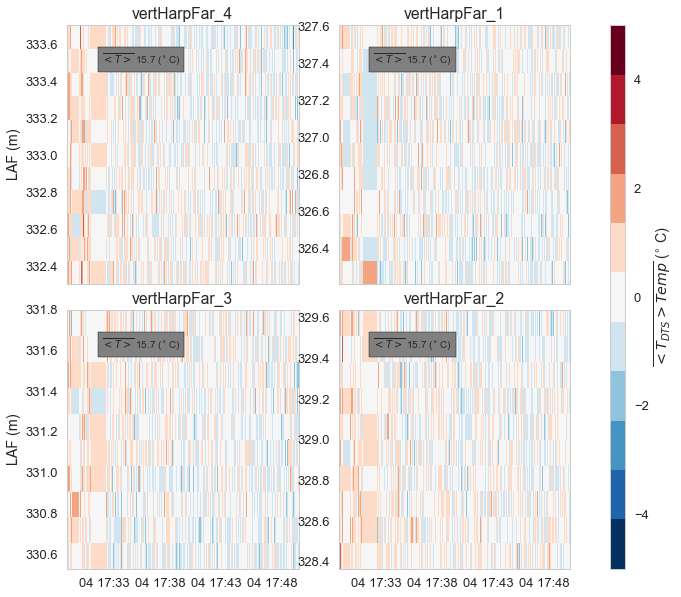

In [8]:
#############################
## Vertical (far) Segments ##
#############################
fig = plt.figure(figsize=(10, 10))
gs = matplotlib.gridspec.GridSpec(2, 3, width_ratios=np.append(np.ones(2) * 16, np.array(1)))
gs.update(wspace=0.25, hspace=0.1)
axNum = 0
cmap_delta = kgraph.cmap_discretize(cm.RdBu_r, 11)

for loc in ds.attrs['locations']:
    if 'vertHarpFar' in loc:
        if axNum == 2:
            axNum = axNum + 1
        ax = plt.subplot(gs[axNum])
        axNum = axNum + 1
        
        # Image of data for each section
        temp_ds = ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc)
        meanSectionTemp = temp_ds.mean(dim='time').mean(dim='location')
        temp_ds = temp_ds - meanSectionTemp
        H = np.ma.masked_array(temp_ds.values, np.isnan(temp_ds))
        t = temp_ds.time.values
        length = temp_ds.LAF.values
        X, Y = np.meshgrid(t, length)

        im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap_delta, vmin=-5, vmax=5)

        if not ax.is_last_row():
            ax.set_xticks([])
        if ax.is_first_col():
            ax.set_ylabel('LAF (m)')
        ax.set_title(loc)
        ax.text(0.15, 0.85, '$\overline{<T>}$ '
                + '{:.1f}'.format(np.asscalar(meanSectionTemp.values)) + ' ($^{\circ}$ C)',
                transform=ax.transAxes,
                bbox=dict(facecolor='grey'))

caxi = plt.subplot(gs[:, -1])
cbar = plt.colorbar(im, cax=caxi, orientation='vertical', spacing='prop')
cbar.ax.set_ylabel('$\overline{<T_{DTS}> Temp}$ ($^{\circ}$ C)')

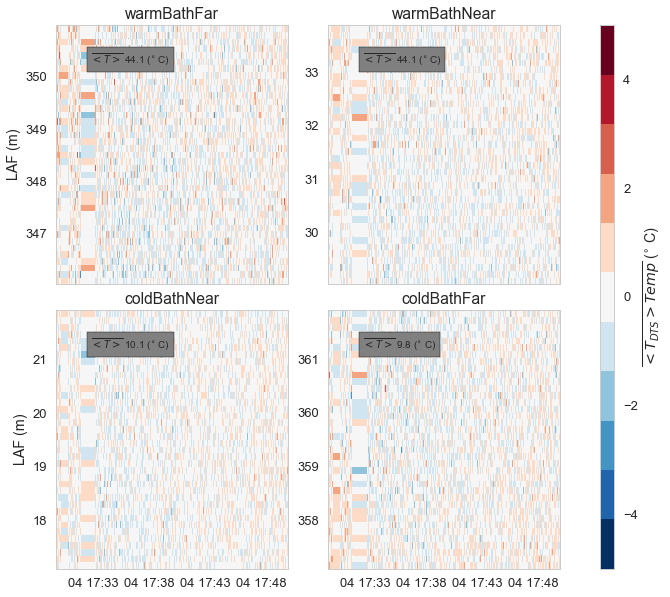

In [9]:
#####################
## Reference Baths ##
#####################
fig = plt.figure(figsize=(10, 10))
gs = matplotlib.gridspec.GridSpec(2, 3, width_ratios=np.append(np.ones(2) * 16, np.array(1)))
gs.update(wspace=0.25, hspace=0.1)
axNum = 0
cmap_delta = kgraph.cmap_discretize(cm.RdBu_r, 11)

for loc in ds.attrs['locations']:
    if 'Bath' in loc:
        if axNum == 2:
            axNum = axNum + 1
        ax = plt.subplot(gs[axNum])
        axNum = axNum + 1
        
        # Image of data for each section
        temp_ds = ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc)
        meanSectionTemp = temp_ds.mean(dim='time').mean(dim='location')
        temp_ds = temp_ds - meanSectionTemp
        H = np.ma.masked_array(temp_ds.values, np.isnan(temp_ds))
        t = temp_ds.time.values
        length = temp_ds.LAF.values
        X, Y = np.meshgrid(t, length)

        im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap_delta, vmin=-5, vmax=5)

        if not ax.is_last_row():
            ax.set_xticks([])
        if ax.is_first_col():
            ax.set_ylabel('LAF (m)')
        ax.set_title(loc)
        ax.text(0.15, 0.85, '$\overline{<T>}$ '
                + '{:.1f}'.format(np.asscalar(meanSectionTemp.values)) + ' ($^{\circ}$ C)',
                transform=ax.transAxes,
                bbox=dict(facecolor='grey'))

caxi = plt.subplot(gs[:, -1])
cbar = plt.colorbar(im, cax=caxi, orientation='vertical', spacing='prop')
cbar.ax.set_ylabel('$\overline{<T_{DTS}> Temp}$ ($^{\circ}$ C)')

In [6]:
# Reference temperatures
refField1 = 'probe1Temperature'
refField2 = 'probe2Temperature'
refField3 = 'probe1Temperature'

refT1 = ds[refField1]
refT2 = ds[refField2]
refT3 = ds[refField3]

# Reference sections
refLoc1 = 'coldBathNear'
refLoc2 = 'warmBathNear'
refLoc3 = 'coldBathFar'

section1 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc1)
section2 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc2)
section3 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc3)

ref_z1 = section1.LAF.mean(dim='location')
ref_z2 = section2.LAF.mean(dim='location')
ref_z3 = section3.LAF.mean(dim='location')

# Amplitudes of stokes/anti-stokes
stokesRatio1 = np.log(section1.Ps / section1.Pas).mean(dim='location')
stokesRatio2 = np.log(section2.Ps / section2.Pas).mean(dim='location')
stokesRatio3 = np.log(section3.Ps / section3.Pas).mean(dim='location')

# Allocate the calibration variables
gamma = np.ones(np.shape(ds.time.values)) * -9999.
C = np.ones(np.shape(ds.time.values)) * -9999.
delta_alpha = np.ones(np.shape(ds.time.values)) * -9999.

# Within each time step solve for the calibration parameters
for n, t in enumerate(ds.time):
    print("\r", 'Time step ' + str(n) + ' of ' + str(np.size(ds.time.values)), end="")

    
    # A matrix
    A = [[1, -refT1.sel(time=t), refT1.sel(time=t) * ref_z1],
         [1, -refT2.sel(time=t), refT2.sel(time=t) * ref_z2],
         [1, -refT3.sel(time=t), refT3.sel(time=t) * ref_z3],
        ]

    # b matrix
    b = [[refT1.sel(time=t) * stokesRatio1.sel(time=t)],
         [refT2.sel(time=t) * stokesRatio2.sel(time=t)],
         [refT3.sel(time=t) * stokesRatio3.sel(time=t)],
        ]

    x = np.linalg.solve(A, b)
    
    gamma[n] = x[0]
    C[n] = x[1]
    delta_alpha[n] = x[2]

 Time step 999 of 1000

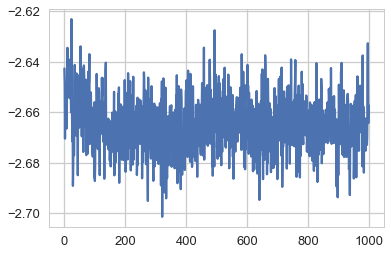

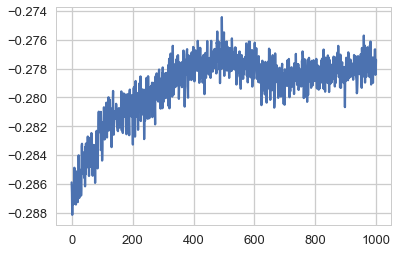

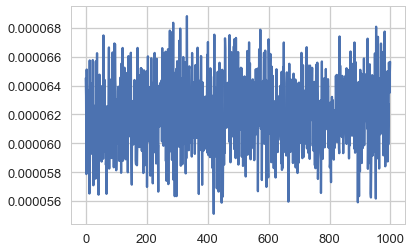

In [7]:
plt.plot(gamma)

plt.figure()
plt.plot(C)

plt.figure()
plt.plot(delta_alpha)

KeyboardInterrupt: 

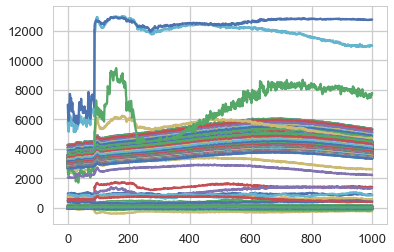

In [43]:
# delta_alpha_interp = (stokesRatio1 - stokesRatio3) / (ref_z3 - ref_z1)
# plt.plot(delta_alpha_interp)

# plt.plot(stokesRatio1)
plt.plot(ds.Ps)
plt.plot(ds.Pas)

In [12]:
#############################
## Recalculate temperature ##
#############################
manualTemp = np.ones(np.shape(ds.temp.values)) * -9999.

for n, t in enumerate(ds.time):
    print("\r", 'Time step ' + str(n) + ' of ' + str(np.size(ds.time.values)), end="")
    manualTemp[n] = gamma[n] / (np.log(ds.Ps.sel(time=t) / ds.Pas.sel(time=t)) + C[n] - delta_alpha[n] * ds.LAF)
    


 Time step 3 of 1000

//anaconda/lib/python3.5/site-packages/dask/array/core.py:2186: RuntimeWarning: divide by zero encountered in true_divide
  dt = op(*vals).dtype
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log


 Time step 999 of 1000

In [29]:
temp_ds = ds.swap_dims({'LAF': 'location'}).sel(location='warmBathNear').swap_dims({'location': 'LAF'})
manualTemp = np.ones(np.shape(temp_ds.temp.values)) * -9999.

for nt, t in enumerate(temp_ds.time):
    for nlaf, laf in enumerate(temp_ds.LAF):
        ds_at_point = temp_ds.sel(time=t).isel(LAF=nlaf)
        manualTemp[nt, nlaf] = (gamma[nt]
                                / (np.log(ds_at_point.Ps / ds_at_point.Pas)
                                   + C[nt] - delta_alpha[nt] * ds_at_point.LAF))



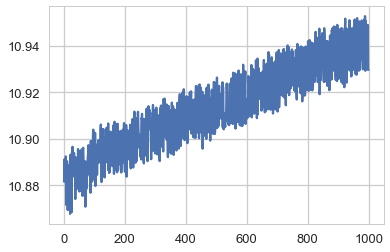

In [32]:
temp_ds['manualTemp'] = (('time', 'LAF'), manualTemp)
temp_ds = temp_ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location='warmBathNear')
plt.plot(temp_ds.mean(dim='location'))

# temp_ds = ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc)
# plt.plot(temp_ds.mean(dim='location'))

In [13]:
ds['manualTemp'] = (('time', 'LAF'), manualTemp)
print(ds)

<xarray.Dataset>
Dimensions:            (LAF: 4193, time: 1000)
Coordinates:
  * LAF                (LAF) float64 -83.06 -82.93 -82.8 -82.67 -82.55 ...
  * time               (time) datetime64[ns] 2017-09-04T17:29:38 ...
    location           (LAF) object '' '' '' '' '' '' '' '' '' '' '' '' '' ...
Data variables:
    Pas                (time, LAF) float64 0.1196 -0.9827 13.01 -1.58 -9.542 ...
    Ps                 (time, LAF) float64 -0.7304 1.216 -0.9891 2.12 -11.28 ...
    temp               (time, LAF) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    probe1Temperature  (time) float64 44.38 44.37 44.37 44.37 44.37 44.37 ...
    probe2Temperature  (time) float64 10.88 10.88 10.89 10.88 10.89 10.88 ...
    fiberStatus        (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    manualTemp         (time, LAF) float64 nan nan nan nan 23.25 -6.01 nan ...
Attributes:
    LAF_beg:    -83.055
    dLAF:       0.127
    LAF_end:    449.746
    locations:  ['vertHarpNear_1', 'Horizontal

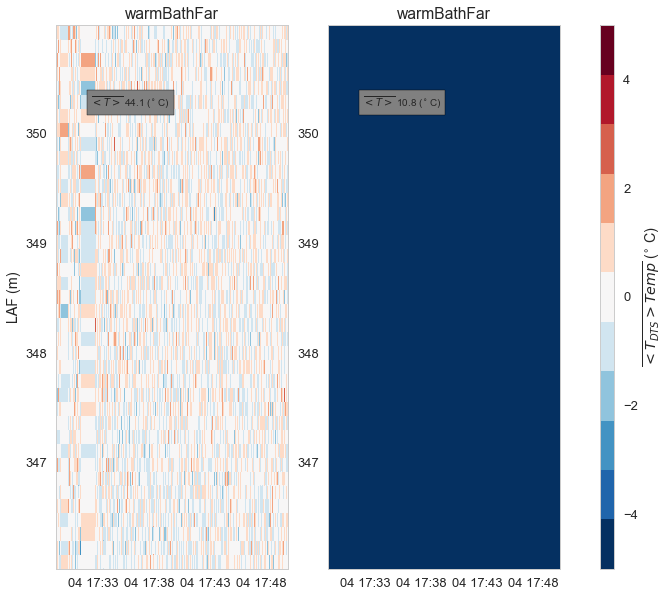

In [14]:
#####################
## Reference Baths ##
#####################

# Check our manually calibrated temperature against the reference bath (warmBathFar)

fig = plt.figure(figsize=(10, 10))
gs = matplotlib.gridspec.GridSpec(1, 3, width_ratios=np.append(np.ones(2) * 16, np.array(1)))
gs.update(wspace=0.25, hspace=0.1)
cmap_delta = kgraph.cmap_discretize(cm.RdBu_r, 11)
loc = 'warmBathFar'

# Image of data for each section - raw temp
ax = plt.subplot(gs[0])
temp_ds = ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc)
meanSectionTemp = temp_ds.mean(dim='time').mean(dim='location')
temp_ds = temp_ds - ds.probe1Temperature

H = np.ma.masked_array(temp_ds.values, np.isnan(temp_ds))
t = temp_ds.time.values
length = temp_ds.LAF.values
X, Y = np.meshgrid(t, length)

im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap_delta, vmin=-5, vmax=5)

if not ax.is_last_row():
    ax.set_xticks([])
if ax.is_first_col():
    ax.set_ylabel('LAF (m)')
ax.set_title(loc)
ax.text(0.15, 0.85, '$\overline{<T>}$ '
        + '{:.1f}'.format(np.asscalar(meanSectionTemp.values)) + ' ($^{\circ}$ C)',
        transform=ax.transAxes,
        bbox=dict(facecolor='grey'))

ax = plt.subplot(gs[1])
temp_ds = ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc)
meanSectionTemp = temp_ds.mean(dim='time').mean(dim='location')
temp_ds = temp_ds - ds.probe1Temperature

H = np.ma.masked_array(temp_ds.values, np.isnan(temp_ds))
t = temp_ds.time.values
length = temp_ds.LAF.values
X, Y = np.meshgrid(t, length)

im = ax.pcolormesh(X.T, Y.T, H, cmap=cmap_delta, vmin=-5, vmax=5)

if not ax.is_last_row():
    ax.set_xticks([])
if ax.is_first_col():
    ax.set_ylabel('LAF (m)')
ax.set_title(loc)
ax.text(0.15, 0.85, '$\overline{<T>}$ '
        + '{:.1f}'.format(np.asscalar(meanSectionTemp.values)) + ' ($^{\circ}$ C)',
        transform=ax.transAxes,
        bbox=dict(facecolor='grey'))

caxi = plt.subplot(gs[:, -1])
cbar = plt.colorbar(im, cax=caxi, orientation='vertical', spacing='prop')
cbar.ax.set_ylabel('$\overline{<T_{DTS}> Temp}$ ($^{\circ}$ C)')

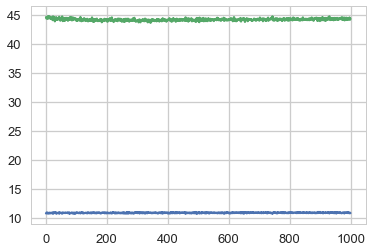

In [15]:
temp_ds = ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc)
plt.plot(temp_ds.mean(dim='location'))

temp_ds = ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc)
plt.plot(temp_ds.mean(dim='location'))